In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from multiprocessing import cpu_count
from joblib import Parallel,delayed
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm

In [2]:
from _Functions_.Constants import *
from _Functions_.EOS_Data import *
from _Functions_.TOV import *
from _Functions_.MOI import *
from _Functions_.Tidal_Properties import *

In [3]:
no_of_cores=cpu_count()
designated_cores= no_of_cores -1

nc= 23 #To avoid core overlapping during multiprocessing
nc_MR= 23 #For MR_Profile

Ec_min= 100 #Mev per fm^3 (To be set according to EOS for stability)
Ec_max= 10000 #Mev per fm^3 (To be set according to EOS for stability)

print ("No. of cores = %i" %no_of_cores + "\nDesignated cores for multiprocessing = %i" %designated_cores)

No. of cores = 4
Designated cores for multiprocessing = 3


In [4]:
path= "_EOS_/SLY4.dat"
EOS_Name= path[6:-4]
Data, CP, EOS= EOS_Data(path)
P2E, E2P= EOS
e,p= Data
min_p,max_p,min_e,max_e= CP

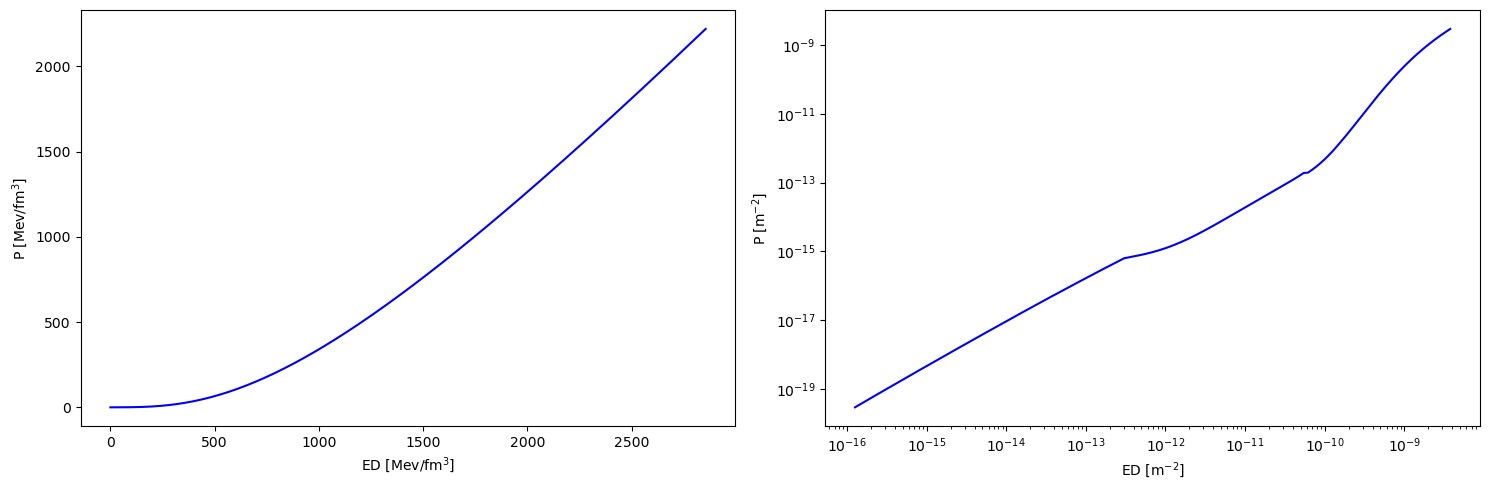

In [5]:
fig, ax = plt.subplots(1,2, figsize= (15,5))

ax[0].plot(e, p, "-", color='blue')
ax[0].set_xlabel(r"ED $\mathrm{[Mev/fm^3]}$")
ax[0].set_ylabel(r"P $\mathrm{[Mev/fm^3]}$")

ax[1].plot(e*Mev_per_fm_cube__to__Pa*Pa__to__per_m_square, p*Mev_per_fm_cube__to__Pa*Pa__to__per_m_square, "-", color='blue')
ax[1].set_xlabel(r"ED $\mathrm{[m^{-2}]}$")
ax[1].set_ylabel(r"P $\mathrm{[m^{-2}]}$")
ax[1].set_xscale("log")
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

In [6]:
def M_R_Ec(EOS,CP):
    P2E, E2P= EOS
    min_p,max_p,min_e,max_e= CP
    
    A= TOV_SOLVER(EOS,CP)
    
    M_list= []
    R_list= []
    
    if (max_e/(Mev_per_fm_cube__to__Pa*Pa__to__per_m_square))<Ec_max:
        Ec_list= np.logspace(np.log10(Ec_min),np.log10(int(max_e/(Mev_per_fm_cube__to__Pa*Pa__to__per_m_square))),nc_MR*designated_cores)
    else:
        Ec_list= np.logspace(np.log10(Ec_min),np.log10(Ec_max),nc_MR*designated_cores)
    
    X= Parallel(n_jobs=designated_cores)(delayed(A.TOV_solve)(Ec) for Ec in tqdm(Ec_list))
        
    for i in range(len(X)):
        
        r_array, riplo, EOS = X[i]
         
        R= r_array[-1]
        M= riplo[0](R)       
        
        R_list.append(R/1000)
        M_list.append(M*(1/Kg__to__m)*(1/M0))
        
    M_array = np.array(M_list)
    Ec_array = np.array(Ec_list)
    R_array = np.array(R_list)
    
    M2Ec = interp1d(M_array, Ec_array, kind= "cubic")
    Ec2M = interp1d(Ec_array, M_array, kind= "cubic")
    M2R = interp1d(M_array, R_array, kind= "cubic")
        
    return R_array, M_array, M2Ec, Ec2M, M2R

In [17]:
R_array, M_array, M2Ec, Ec2M, M2R = M_R_Ec(EOS,CP)

E_can= M2Ec(1.4)
E_max= M2Ec(np.max(M_array))

  0%|          | 0/69 [00:00<?, ?it/s]

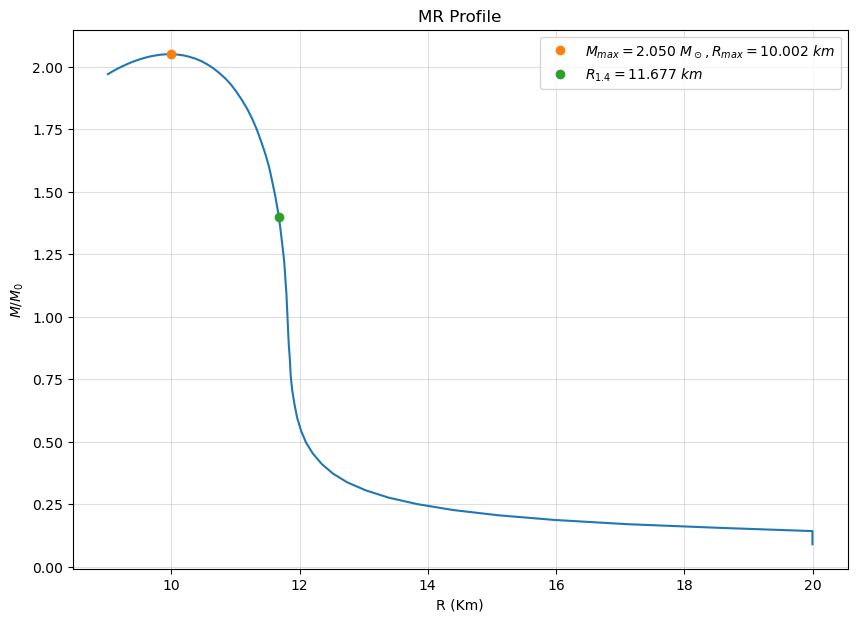

In [18]:
fig, ax = plt.subplots(1, figsize = (10,7))

ax.plot(R_array,M_array)
ax.plot(M2R(np.max(M_array)),np.max(M_array),"o", label= "$M_{max}= %0.3f \ M_\odot, R_{max}= %0.3f \ km$" %(np.max(M_array),M2R(np.max(M_array))) )
ax.plot(M2R(1.4),1.4,"o", label= "$R_{1.4}= %0.3f \ km$" %(M2R(1.4)) )
ax.legend()
ax.set_xlabel("R (Km)")
ax.set_ylabel("$M/M_0$")
ax.set_title("MR Profile")
ax.grid(alpha= 0.4)

plt.show()

fig.savefig("Plots/MR-profile.pdf")

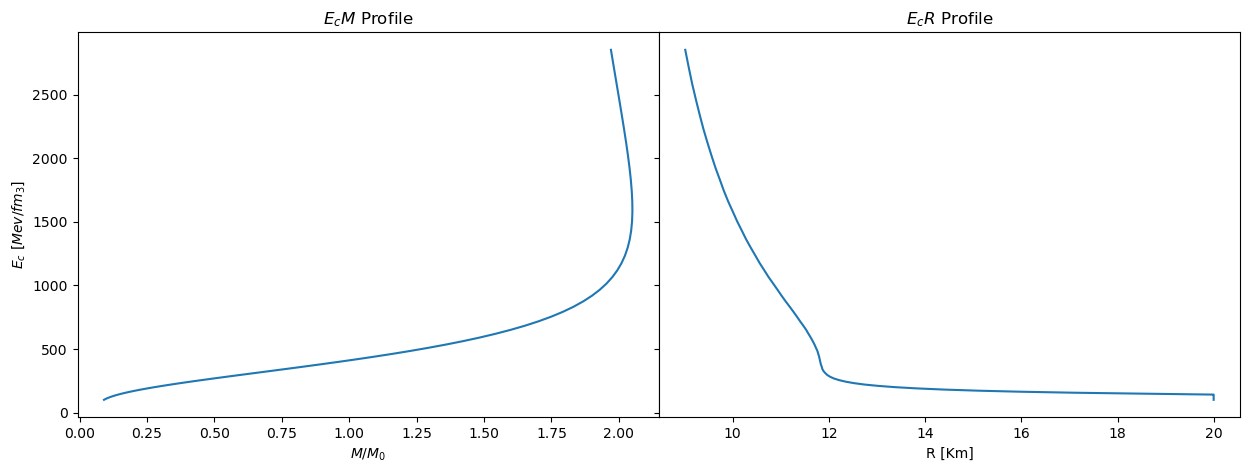

In [11]:
fig, ax = plt.subplots(1,2, figsize = (15,5), sharey= True)
fig.subplots_adjust(wspace=0)

ax[0].plot(M_array,M2Ec(M_array))
ax[0].set_xlabel("$M/M_0$")
ax[0].set_ylabel("$E_c \ [Mev/fm_3]$")
ax[0].set_title("$E_cM$ Profile")

ax[1].plot(R_array,M2Ec(M_array))
ax[1].set_xlabel("R [Km]")
ax[1].set_title("$E_cR$ Profile")

plt.show()

fig.savefig("Plots/Density-profile.pdf")

In [12]:
r_array, riplo, EOS = TOV_SOLVER(EOS,CP).TOV_solve(E_can)
r2m, r2pr, r2psi, r2dpr_de, r2dpr_dr, r2dpsi_dr, r2de_dr = riplo

In [13]:
r__array, riplo, EOS = TOV_SOLVER(EOS,CP).TOV_solve(E_max)
r_2m, r_2pr, r_2psi, r_2dpr_de, r_2dpr_dr, r_2dpsi_dr, r_2de_dr = riplo

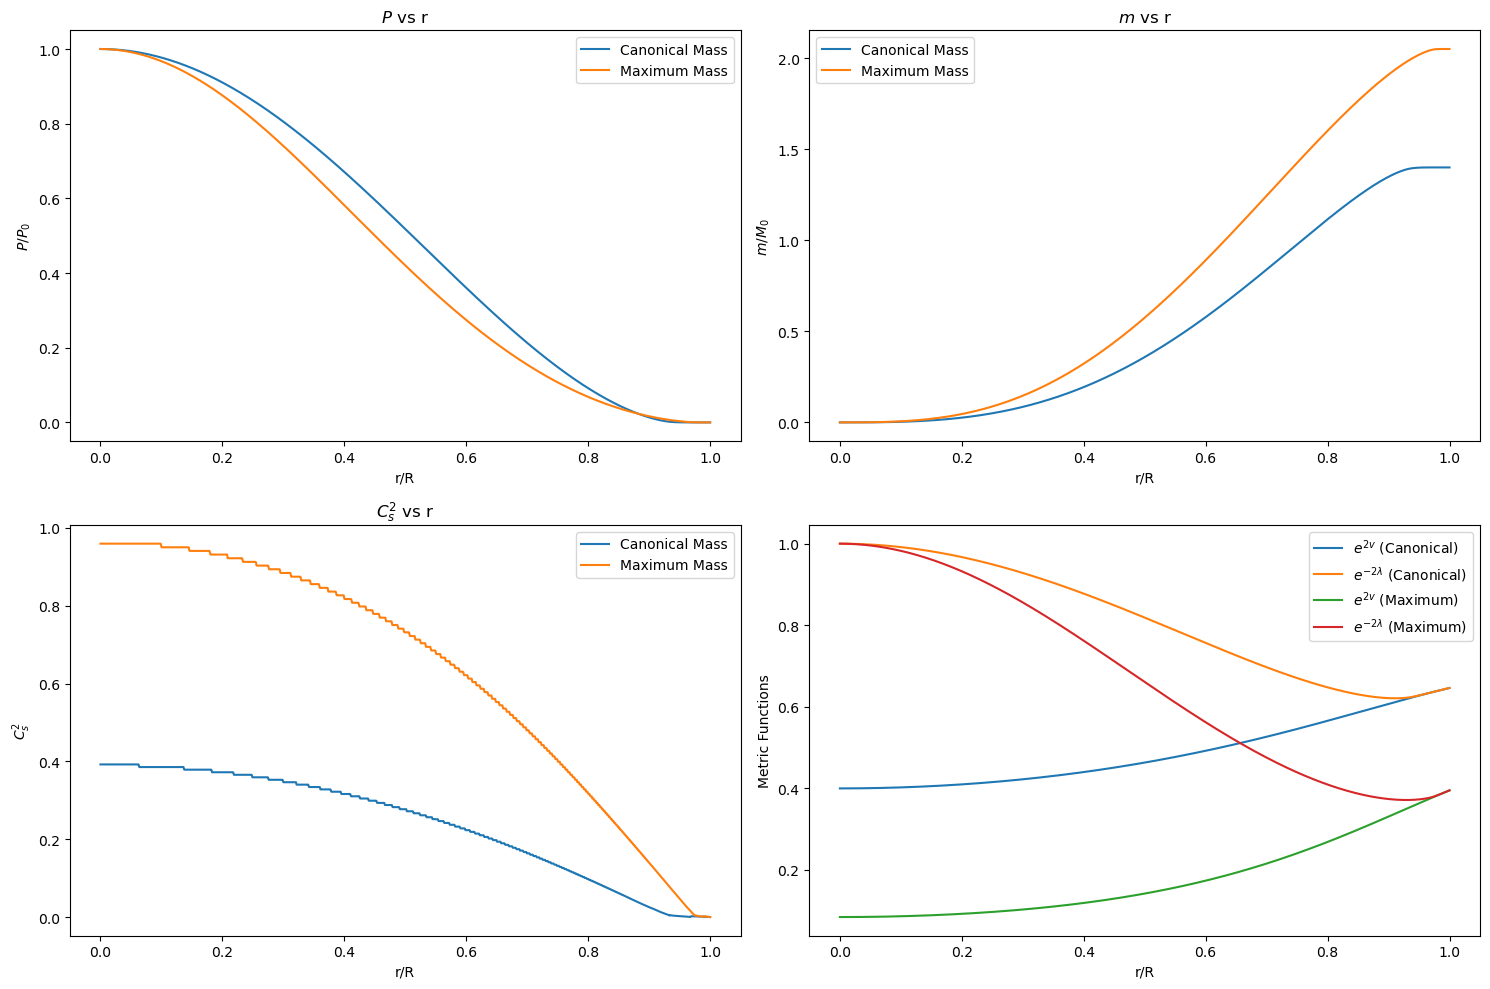

In [14]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(r_array/r_array[-1],r2pr(r_array)/r2pr(r_array[0]), label= "Canonical Mass")
ax[0,0].plot(r__array/r__array[-1],r_2pr(r__array)/r_2pr(r__array[0]), label= "Maximum Mass")
ax[0,0].legend()
ax[0,0].set_xlabel("r/R")
ax[0,0].set_ylabel("$P/P_0$")
ax[0,0].set_title("$P$ vs r")

ax[0,1].plot(r_array/r_array[-1],r2m(r_array)*(1/Kg__to__m)*(1/M0), label= "Canonical Mass")
ax[0,1].plot(r__array/r__array[-1],r_2m(r__array)*(1/Kg__to__m)*(1/M0), label= "Maximum Mass")
ax[0,1].legend()
ax[0,1].set_xlabel("r/R")
ax[0,1].set_ylabel("$m/M_0$")
ax[0,1].set_title("$m$ vs r")

ax[1,0].plot(r_array/r_array[-1],r2dpr_de(r_array), label= "Canonical Mass")
ax[1,0].plot(r__array/r__array[-1],r_2dpr_de(r__array), label= "Maximum Mass")
ax[1,0].legend()
ax[1,0].set_xlabel("r/R")
ax[1,0].set_ylabel("$C^2_{s}$")
ax[1,0].set_title("$C^2_{s}$ vs r")

ax[1,1].plot(r_array/r_array[-1],np.e**(2*r2psi(r_array)), label= "$e^{2v}$ (Canonical)")
ax[1,1].plot(r_array/r_array[-1],np.e**(-2*Lamda(r2m(r_array),r_array)), label= "$e^{-2\lambda}$ (Canonical)")

ax[1,1].plot(r__array/r__array[-1],np.e**(2*r_2psi(r__array)), label= "$e^{2v}$ (Maximum)")
ax[1,1].plot(r__array/r__array[-1],np.e**(-2*Lamda(r_2m(r__array),r__array)), label= "$e^{-2\lambda}$ (Maximum)")

ax[1,1].legend()
ax[1,1].set_xlabel("r/R")
ax[1,1].set_ylabel("Metric Functions")

fig.tight_layout()
plt.show()

fig.savefig("Plots/mass-pressure-sound_speed-profile.pdf")

In [7]:
def MI(EOS,CP):
    
    min_p,max_p,min_e,max_e= CP
    I_array= []
    I_bar_array= []
    M_array= []
    
    A= TOV_SOLVER(EOS,CP)

    if (max_e/(Mev_per_fm_cube__to__Pa*Pa__to__per_m_square))<Ec_max:
        Ec_list= np.logspace(np.log10(Ec_min),np.log10(int(max_e/(Mev_per_fm_cube__to__Pa*Pa__to__per_m_square))),nc_MR*designated_cores)
    else:
        Ec_list= np.logspace(np.log10(Ec_min),np.log10(Ec_max),nc_MR*designated_cores)
        
    X= Parallel(n_jobs=designated_cores)(delayed(A.TOV_solve)(Ec) for Ec in tqdm(Ec_list))

    Y= Parallel(n_jobs=designated_cores)(delayed(MOI_SOLVER(X[i]).MOI_Solve)() for i in tqdm(range(len(X))))

    for i in range(len(Y)):
        I, I_bar, M = Y[i]
        
        I_array.append(I)
        I_bar_array.append(I_bar)
        M_array.append(M)

    I_array= np.array(I_array)
    I_bar_array= np.array(I_bar_array)
    M_array= np.array(M_array)

    M2I_bar= interp1d(M_array,I_bar_array,kind="cubic")
    M2I= interp1d(M_array,I_array,kind="cubic")
    
    MI_inpo= M2I, M2I_bar
    
    return M_array, MI_inpo

In [8]:
M_array, MI_inpo = MI(EOS,CP)
M2I, M2I_bar= MI_inpo

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

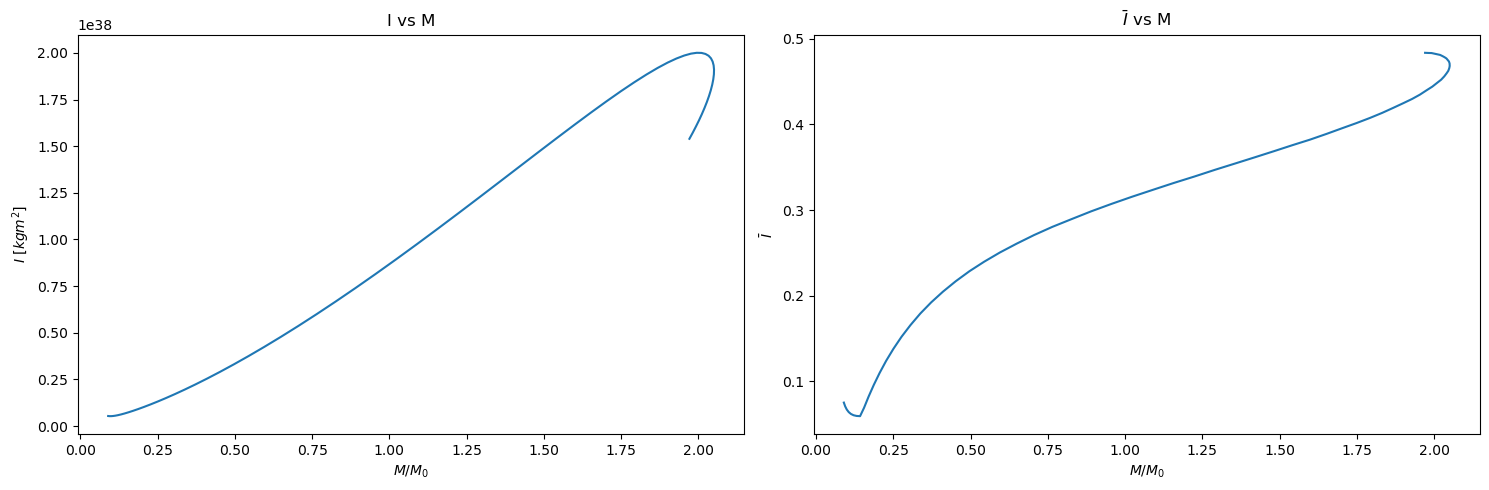

In [9]:
fig, ax = plt.subplots(1,2, figsize= (15,5))

ax[0].plot(M_array, M2I(M_array), "-")
ax[1].plot(M_array, M2I_bar(M_array), "-")

ax[0].set_xlabel("$M/M_0$")
ax[0].set_ylabel("$I \ [kgm^2]$")
ax[0].set_title("I vs M")

ax[1].set_xlabel("$M/M_0$")
ax[1].set_ylabel("$\\bar{I}$")
ax[1].set_title("$\\bar{I}$ vs M")

plt.tight_layout()
plt.show()

fig.savefig("Plots/MI.pdf")

In [12]:
def Tidal(EOS,CP):
    min_p,max_p,min_e,max_e= CP
    M_array= []
    k2_array= []
    l_array= []
    C_array= []
    
    A= TOV_SOLVER(EOS,CP)

    if (max_e/(Mev_per_fm_cube__to__Pa*Pa__to__per_m_square))<Ec_max:
        Ec_list= np.logspace(np.log10(Ec_min),np.log10(int(max_e/(Mev_per_fm_cube__to__Pa*Pa__to__per_m_square))),nc_MR*designated_cores)
    else:
        Ec_list= np.logspace(np.log10(Ec_min),np.log10(Ec_max),nc_MR*designated_cores)
        
    X= Parallel(n_jobs=designated_cores)(delayed(A.TOV_solve)(Ec) for Ec in tqdm(Ec_list))

    Y= Parallel(n_jobs=designated_cores)(delayed(Tidal_SOLVER(X[i]).Love_solve)() for i in tqdm(range(len(X))))

    for i in range(len(Y)):
        M, k2, l, C = Y[i]
        
        M_array.append(M)
        k2_array.append(k2)
        l_array.append(l)
        C_array.append(C)

    M_array= np.array(M_array)
    k2_array= np.array(k2_array)
    l_array= np.array(l_array)
    C_array= np.array(C_array)

    M2k2= interp1d(M_array,k2_array,kind="cubic")
    M2l= interp1d(M_array,l_array,kind="cubic")
    M2C= interp1d(M_array,C_array,kind="cubic")
    
    Miplo= M2k2, M2l, M2C
    
    return M_array, Miplo

In [13]:
M_array, Miplo= Tidal(EOS,CP)

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

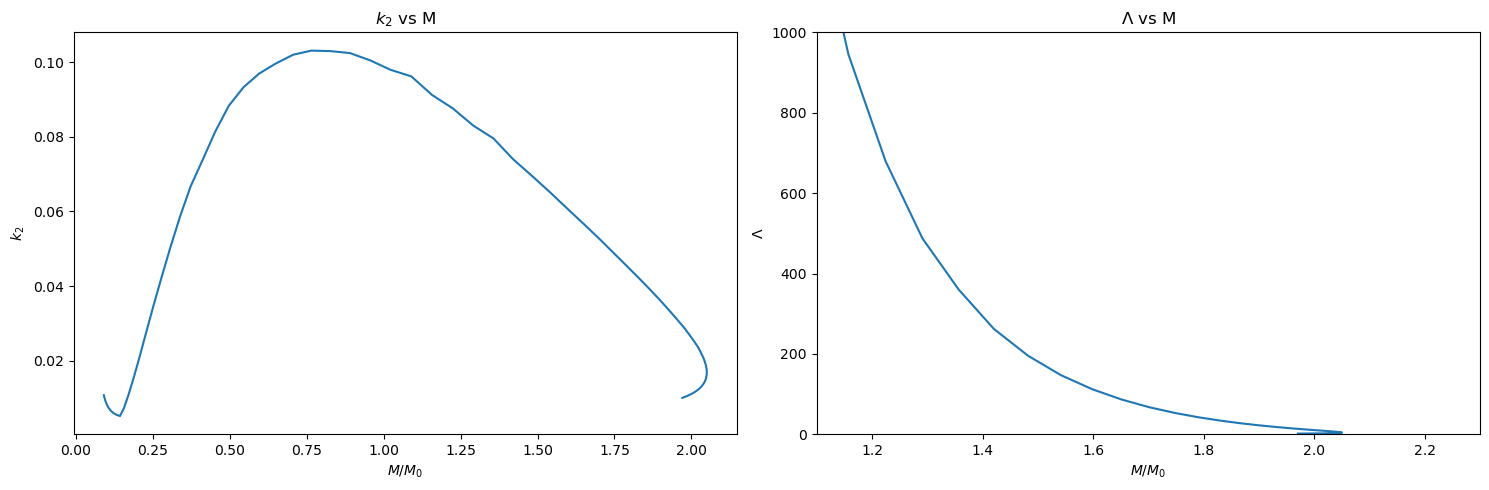

In [14]:
fig, ax = plt.subplots(1,2, figsize= (15,5))

ax[0].plot(M_array, Miplo[0](M_array), "-")
ax[1].plot(M_array, Miplo[1](M_array), "-")
        
ax[0].set_xlabel("$M/M_0$")
ax[0].set_ylabel("$k_2$")
ax[0].set_title("$k_2$ vs M")

ax[1].set_xlabel("$M/M_0$")
ax[1].set_ylabel("$\\Lambda$")
ax[1].set_title("$\\Lambda$ vs M")
ax[1].set_ylim(0,1000)
ax[1].set_xlim(1.1,2.3)

plt.tight_layout()
plt.show()

fig.savefig("Plots/Tidal_Deformability.pdf")

In [19]:
M_max= np.max(M_array).tolist()
R_max= M2R(M_max).tolist()
R_can= M2R(1.4).tolist()
I_bar_max= MI_inpo[1](M_max).tolist()
I_bar_can= MI_inpo[1](1.4).tolist()
k2_max= Miplo[0](M_max).tolist()
k2_can= Miplo[0](1.4).tolist()
l_max= Miplo[1](M_max).tolist()
l_can= Miplo[1](1.4).tolist()    
    
Data= [round(M_max, 3), 
        round(R_max, 3), 
        round(R_can, 3), 
        round(I_bar_max, 3), 
        round(I_bar_can, 3), 
        round(k2_max, 3), 
        round(k2_can, 3), 
        round(l_max, 3), 
        round(l_can, 3)]

Tabel = pd.DataFrame(Data, columns= [EOS_Name], index= ["$M_{max}/M_0$",
                                                "$R_{max} \ (km)$ ",
                                                "$R_{1.4} \ (km)$", 
                                                "$\\bar{I}_{max}$", 
                                                "$\\bar{I}_{1.4}$", 
                                                "$k_{2_{max}}$", 
                                                "$k_{2_{1.4}}$", 
                                                "$\Lambda_{max}$", 
                                                "$\Lambda_{1.4}$"])

In [20]:
display(Tabel)

,SLY4
$M_{max}/M_0$,2.050
$R_{max} \ (km)$,10.002
$R_{1.4} \ (km)$,11.677
$\bar{I}_{max}$,0.468
$\bar{I}_{1.4}$,0.359
$k_{2_{max}}$,0.017
$k_{2_{1.4}}$,0.076
$\Lambda_{max}$,4.476
$\Lambda_{1.4}$,290.930
